# Libraries

In [3]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [6]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
#from Utils import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [7]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [12]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [14]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [15]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 1636/1636 [08:22<00:00,  3.26it/s]


In [16]:
dataframes[30]

('data/all_nano_structures_single_domain/6rbb.pdb',
              X          Y       Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     0.694000  -4.277000   5.308  174.20274           3.721274   
 1    -2.990000  -4.576000   5.740   75.06714           4.198928   
 2    -6.508000  -3.784000   4.701  105.09344           3.805953   
 3    -8.875000  -3.795000   7.749  147.13074           3.833386   
 4    -6.175000  -5.348000   9.939  165.19184           3.788165   
 ..         ...        ...     ...        ...                ...   
 478 -33.832001 -20.900999  10.996  117.14784           4.169421   
 479 -33.150002 -18.483999   8.138  119.12034           4.082392   
 480 -34.498001 -14.935000   8.444  117.14784           4.093996   
 481 -34.692001 -12.858000   5.268  105.09344           4.145524   
 482 -34.766998  -9.058000   5.304  105.09344           3.800911   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3.721274               1                      1  


In [16]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [17]:
def dataframe_to_graph(df, neighborhood_radius=5.0, include_coordinates=True, include_small_molecules=True):
    """Convert a DataFrame into a graph for GNN."""
    # Base node features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count']
    if include_small_molecules:
        features_to_include.append('Small_Molecules_Found')

    node_features = df[features_to_include].values

    # Optionally include coordinates as part of the node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])  # Combine features and coordinates

    node_features = torch.tensor(node_features, dtype=torch.float)

    # Build edges based on neighborhood radius
    coords = df[['X', 'Y', 'Z']].values  # Use coordinates for distance computation
    edge_index = []
    edge_attr = []

    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= neighborhood_radius:
                # Add bidirectional edges
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist])  # Use distance as edge feature
                edge_attr.append([dist])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)  # Shape: [num_edges, edge_features]

    # Graph data object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )

    return data


In [18]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = dataframe_to_graph(df, neighborhood_radius=5.0, include_coordinates=True, include_small_molecules=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1636 [00:00<?]

KeyboardInterrupt: 

In [19]:
graphs[2]

('data/all_nano_structures_single_domain/3g9a.pdb',
 Data(x=[355, 8], edge_index=[2, 940], edge_attr=[940, 1]))

In [20]:
import pickle 

# Save multiple graphs with associated PDB filenames
def save_graphs(graphs, output_dir='output_dir'):
    graphs_dir = os.path.join(output_dir, 'graphs')
    os.makedirs(graphs_dir, exist_ok=True)
    
    for pdb_file, graph in graphs:
        # Sanitize pdb_file to create a valid filename
        safe_filename = pdb_file.replace('/', '_').replace('\\', '_')
        filename = os.path.join(graphs_dir, f'{safe_filename}.pkl')
        with open(filename, 'wb') as file:
            pickle.dump(graph, file)
        print(f"Graph for {pdb_file} saved as {filename}")

# Load multiple graphs with associated PDB filenames
def load_graphs(output_dir='output_dir'):
    graphs_dir = os.path.join(output_dir, 'graphs')
    graphs = []
    
    for filename in sorted(os.listdir(graphs_dir)):
        if filename.endswith('.pkl'):
            pdb_file = filename.replace('.pkl', '').replace('_', '/')  # Reconstruct pdb_file
            with open(os.path.join(graphs_dir, filename), 'rb') as file:
                graph = pickle.load(file)
            graphs.append((pdb_file, graph))
            print(f"Loaded graph for {pdb_file} from {filename}")
    return graphs

In [21]:
# Example usage
# Assuming `graphs` contains tuples (pdb_file, graph)
save_graphs(graphs, output_dir='output_dir')

# When you want to reload:
#loaded_graphs = load_graphs(output_dir='output_dir')


Graph for data/all_nano_structures_single_domain/7l6v.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_7l6v.pdb.pkl
Graph for data/all_nano_structures_single_domain/6heq.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_6heq.pdb.pkl
Graph for data/all_nano_structures_single_domain/3g9a.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_3g9a.pdb.pkl
Graph for data/all_nano_structures_single_domain/6hdb.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_6hdb.pdb.pkl
Graph for data/all_nano_structures_single_domain/8hdp.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_8hdp.pdb.pkl
Graph for data/all_nano_structures_single_domain/4pou.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_4pou.pdb.pkl
Graph for data/all_nano_structures_single_domain/6vcb.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_6vcb.pdb.pkl
Graph for data/all_nano_structures_single

In [22]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Extract the PyTorch Geometric Data object from your graphs list
pdb_file, data = graphs[2]

# Convert to NetworkX for visualization
G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


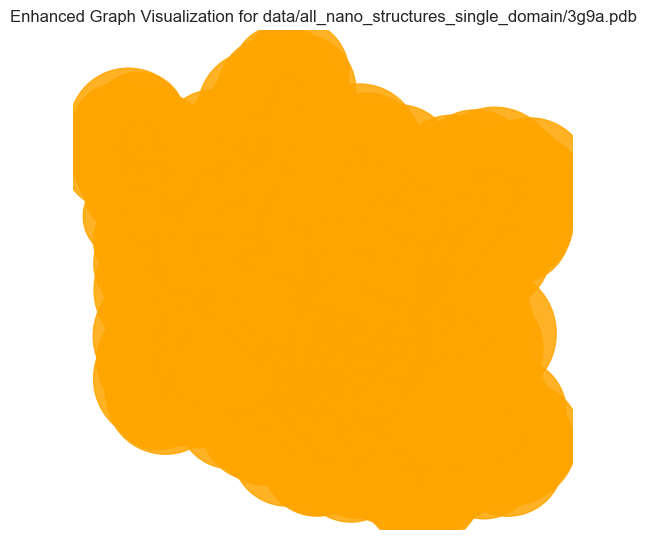

In [23]:
def visualize_graph(G, pdb_file, highlight_nodes=None):
    """Enhanced visualization with improved colors and visibility."""
    plt.figure(figsize=(5, 5))
    
    # Use spring layout for better distribution
    pos = nx.spring_layout(G, seed=42)
    
    # Extract attributes for visualization
    node_sizes = [max(20, node[1]['x'][0] * 50) for node in G.nodes(data=True)]  # Scale and set a minimum size
    edge_weights = [max(0.5, edge[2]['edge_attr'][0] * 2) for edge in G.edges(data=True)]  # Scale and set a minimum width
    
    # Highlight specific nodes if provided
    if highlight_nodes:
        node_colors = [
            'red' if node in highlight_nodes else 'orange' for node in G.nodes
        ]
    else:
        node_colors = 'orange'
    
    # Draw the graph with enhanced visibility
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        edge_color=edge_weights,
        edge_cmap=plt.cm.cool,  # Use a more visible colormap
        node_color=node_colors,
        cmap=plt.cm.plasma,  # Distinguishable node colors
        alpha=0.85  # Set opacity for better visibility
    )
    
    # Add a title
    plt.title(f"Enhanced Graph Visualization for {pdb_file}")
    plt.show()

# Use the function
visualize_graph(G, pdb_file)


Pymol visualization of the same protein: 

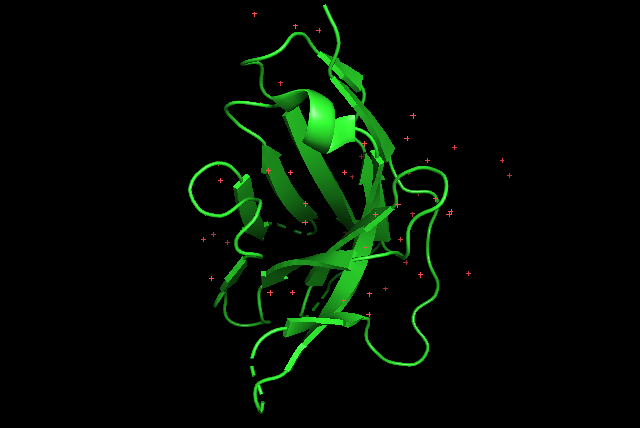

In [41]:
from IPython.display import Image, display

# Path to your PNG file
image_path = "data/8e1b_pymol_file.png"  # Replace with the actual path to your saved PNG

# Display the image
display(Image(filename=image_path))


DO the representation makes sense?

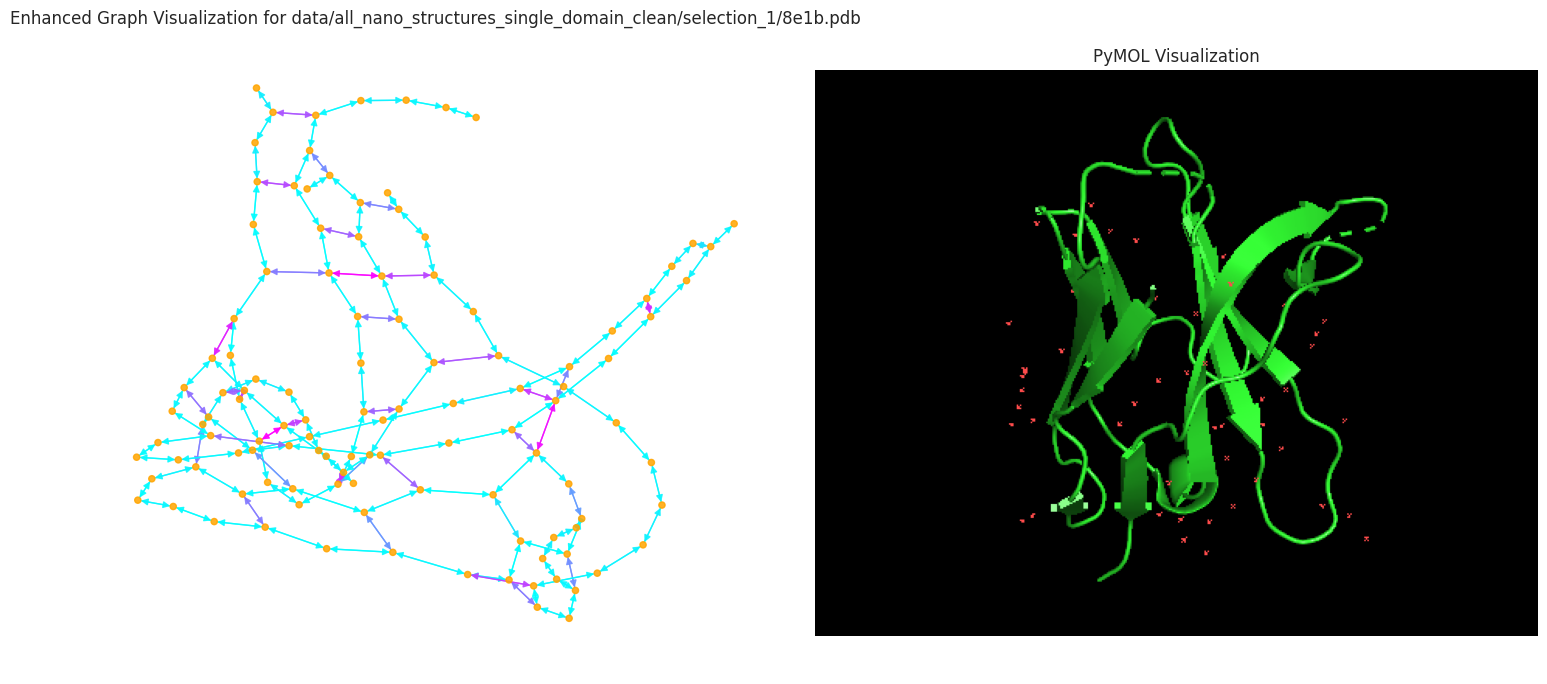

In [43]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_and_pymol(G, pdb_file, pymol_image_path, highlight_nodes=None):
    """Visualize the graph and PyMOL image side by side."""
    # Set up a side-by-side figure layout
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Visualization 1: Graph
    ax1 = axes[0]
    plt.sca(ax1)  # Set current axis to the first subplot
    
    # Use spring layout for better distribution
    pos = nx.spring_layout(G, seed=42)
    
    # Extract attributes for visualization
    node_sizes = [max(20, node[1]['x'][0] * 50) for node in G.nodes(data=True)]  # Scale and set a minimum size
    edge_weights = [max(0.5, edge[2]['edge_attr'][0] * 2) for edge in G.edges(data=True)]  # Scale and set a minimum width
    
    # Highlight specific nodes if provided
    if highlight_nodes:
        node_colors = [
            'red' if node in highlight_nodes else 'orange' for node in G.nodes
        ]
    else:
        node_colors = 'orange'
    
    # Draw the graph with enhanced visibility
    nx.draw(
        G,
        pos,
        ax=ax1,  # Plot on the current axis
        with_labels=False,
        node_size=node_sizes,
        edge_color=edge_weights,
        edge_cmap=plt.cm.cool,  # Use a more visible colormap
        node_color=node_colors,
        cmap=plt.cm.plasma,  # Distinguishable node colors
        alpha=0.85  # Set opacity for better visibility
    )
    ax1.set_title(f"Enhanced Graph Visualization for {pdb_file}")
    
    # Visualization 2: PyMOL Image
    ax2 = axes[1]
    ax2.axis('off')  # Turn off the axis for the image
    img = plt.imread(pymol_image_path)  # Read the PyMOL PNG image
    ax2.imshow(img)  # Display the image
    ax2.set_title("PyMOL Visualization")
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
visualize_graph_and_pymol(
    G, 
    pdb_file="data/all_nano_structures_single_domain_clean/selection_1/8e1b.pdb", 
    pymol_image_path="data/8e1b_pymol_file_rot.png"
)


Save the graph informations for overlay in pymol and verification of a meaningful graph creation: 

In [24]:
import pandas as pd

# Assuming `graph` is a single PyTorch Geometric Data object
def extract_graph_info(graph, feature_names):
    # Extract coordinates (last 3 columns if include_coordinates=True)
    coords = graph.x[:, -3:].numpy()  # Extract X, Y, Z coordinates
    
    # Extract node features
    features = graph.x[:, :-3].numpy()  # Remaining features (excluding coordinates)

    # Combine coordinates and features into a DataFrame
    data = pd.DataFrame(coords, columns=['X', 'Y', 'Z'])
    for i, feature_name in enumerate(feature_names[:-3]):  # Skip coordinate labels
        data[feature_name] = features[:, i]
    
    return data

# Example usage:
feature_names = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found', 'X', 'Y', 'Z']
graph_info_df = extract_graph_info(graph, feature_names)

# Save the DataFrame to a CSV for manual inspection or overlay
graph_info_df.to_csv("graph_info.csv", index=False)


# Dataloader

In [25]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

def split_and_batch_graphs(graphs, batch_size=16, train_ratio=0.8, seed=42):
    """
    Split the graphs into train and test datasets, and create DataLoaders for batching.

    Parameters:
    - graphs (list): List of `torch_geometric.data.Data` graphs.
    - batch_size (int): Batch size for the DataLoader.
    - train_ratio (float): Proportion of data to use for training.
    - seed (int): Random seed for reproducibility.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - test_loader (DataLoader): DataLoader for the testing set.
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Split into train and test sets
    train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
    # Create DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [26]:
# Example Usage
# If `graphs` already contains only `Data` objects, no need to unpack
train_loader, test_loader = split_and_batch_graphs(graphs, batch_size=16, train_ratio=0.8)

# Check the loaders
for batch in train_loader:
    print(batch)
    break


[('data/all_nano_structures_single_domain/4pou.pdb', 'data/all_nano_structures_single_domain/6wpw.pdb', 'data/all_nano_structures_single_domain/8wg8.pdb', 'data/all_nano_structures_single_domain/5c1m.pdb', 'data/all_nano_structures_single_domain/8ysf.pdb', 'data/all_nano_structures_single_domain/7nvo.pdb', 'data/all_nano_structures_single_domain/1ol0.pdb', 'data/all_nano_structures_single_domain/8et0.pdb', 'data/all_nano_structures_single_domain/7x2f.pdb', 'data/all_nano_structures_single_domain/4kml.pdb', 'data/all_nano_structures_single_domain/6oz6.pdb', 'data/all_nano_structures_single_domain/8v9w.pdb', 'data/all_nano_structures_single_domain/6heq.pdb', 'data/all_nano_structures_single_domain/8rmn.pdb', 'data/all_nano_structures_single_domain/7zkz.pdb', 'data/all_nano_structures_single_domain/7ul2.pdb'), DataBatch(x=[21083, 8], edge_index=[2, 52162], edge_attr=[52162, 1], batch=[21083], ptr=[17])]


Here's a breakdown of the components:

x=[20562, 8]: There are 20,562 nodes, each with 8 features (including optional 3D coordinates, average distances, etc., from your Data creation process).
edge_index=[2, 50880]: There are 50,880 edges in the batch, represented as a 2-row tensor where each column corresponds to an edge (source node, target node).
edge_attr=[50880, 1]: Each edge has 1 feature (likely the distance, as per your graph creation process).
batch=[20562]: This tensor indicates which graph each node belongs to, mapping each node to its graph in the batch.
ptr=[17]: This tensor provides pointers to the start indices of graphs in the batch. If you have 17 graphs in the batch, it means they have been concatenated into this single batch.
Interpretation:
This is a batched representation of your graphs, ready to be fed into a GNN model. Each component of the DataBatch provides the necessary information for processing multiple graphs simultaneously.

## Does this makes sense?

In typical machine learning scenarios like image processing, a "batch" contains a specific number of examples (e.g., 16 images in one batch). For your graph dataset, the batch contains multiple graphs, but they are combined into a single structure for efficient processing.

Here’s why it looks like "everything is together":

PyTorch Geometric combines all the nodes, edges, and features of the graphs in a batch into a single data structure.
The batch tensor within the DataBatch object is the key to separating the graphs. It tells the model which nodes and edges belong to which graph.
Let’s clarify this:

Example
If you batch 3 small graphs:

Graph 1: 4 nodes, 5 edges.
Graph 2: 3 nodes, 4 edges.
Graph 3: 5 nodes, 6 edges.
The batched result looks like this:

Nodes (x): Combined node features for all graphs, shape [12, features] (4+3+5 = 12 nodes).
Edges (edge_index): Combined edges, shape [2, 15] (5+4+6 = 15 edges).
Batch (batch): Tensor of size 12, assigning nodes to graphs, e.g., [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2].
Separation within a Batch
The batch tensor allows you to:

Identify which nodes belong to which graph.
Identify which edges are part of each graph.
The ptr tensor in the DataBatch object provides pointers to separate the graphs during training.

In [30]:
print(batch.ptr)  # Shows the start indices of each graph
num_graphs = len(batch.ptr) - 1
print(f"Number of graphs in the batch: {num_graphs}")

AttributeError: 'list' object has no attribute 'ptr'

In [34]:
# Check the structure of your data
sample_data = next(iter(train_loader))
print("Type of sample_data:", type(sample_data))
print("Content of sample_data:", sample_data[0] if isinstance(sample_data, list) else sample_data)

Type of sample_data: <class 'list'>
Content of sample_data: ('data/all_nano_structures_single_domain/6oca.pdb', 'data/all_nano_structures_single_domain/7wu3.pdb', 'data/all_nano_structures_single_domain/6ram.pdb', 'data/all_nano_structures_single_domain/7d4b.pdb', 'data/all_nano_structures_single_domain/5c1m.pdb', 'data/all_nano_structures_single_domain/7o06.pdb', 'data/all_nano_structures_single_domain/8k45.pdb', 'data/all_nano_structures_single_domain/7ckz.pdb', 'data/all_nano_structures_single_domain/8ug9.pdb', 'data/all_nano_structures_single_domain/7zkz.pdb', 'data/all_nano_structures_single_domain/8rmn.pdb', 'data/all_nano_structures_single_domain/1kxq.pdb', 'data/all_nano_structures_single_domain/6her.pdb', 'data/all_nano_structures_single_domain/6wpw.pdb', 'data/all_nano_structures_single_domain/8g7b.pdb', 'data/all_nano_structures_single_domain/8j1n.pdb')


In [35]:
# Check the structure of your data
#sample_data = next(iter(train_loader))
print("Type of sample_data:", type(graphs))
print("Content of sample_data:", graphs[0] if isinstance(sample_data, list) else sample_data)

Type of sample_data: <class 'list'>
Content of sample_data: ('data/all_nano_structures_single_domain/7l6v.pdb', Data(x=[1029, 8], edge_index=[2, 2720], edge_attr=[2720, 1]))


In [47]:
# Check the structure of your data
print("Type of graphs:", type(graphs))
print("Length of graphs:", len(graphs))
print("Type of first graph:", type(graphs[0]))
print("Content of first graph:", graphs[0])

Type of graphs: <class 'list'>
Length of graphs: 221
Type of first graph: <class 'tuple'>
Content of first graph: ('data/all_nano_structures_single_domain/7l6v.pdb', Data(x=[1029, 8], edge_index=[2, 2720], edge_attr=[2720, 1]))


In [54]:
# 1. Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [55]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training without padding
    
    Args:
        graph_tuples: List of tuples (filename, PyG Data object)
        batch_size: Size of each batch
        train_ratio: Ratio of data to use for training
        shuffle: Whether to shuffle the data
    """
    # Extract PyG Data objects from tuples
    graphs = [g[1] for g in graph_tuples]  # Get the Data object from each tuple

    # Split into train and test sets
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    # Create data loaders
    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    # Get dimensions for model initialization
    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)  # Number of features per node

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Batch size: {batch_size}")

    return train_loader, test_loader, in_channels

def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)



In [80]:
class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=64, num_heads=4):
        super(ProteinGraphVAE, self).__init__()
        self.in_channels = in_channels

        # Feature indices for different types of features
        self.coord_indices = slice(-3, None)  # Last 3 features are coordinates
        self.mass_index = 0  # Avg_Mass
        self.distance_indices = slice(1, 3)  # Avg_Neighbor_Dist, Max_Neighbor_Dist
        self.count_index = 3  # Neighbor_Count
        self.small_mol_index = 4  # Small_Molecules_Found

        # Encoder
        self.encoder_conv1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.encoder_conv2 = GATConv(hidden_channels * num_heads, hidden_channels)

        # Single latent space
        self.fc_mu = nn.Linear(hidden_channels, latent_channels)
        self.fc_logvar = nn.Linear(hidden_channels, latent_channels)

        # Feature-specific decoders from shared latent space
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU()
        )

        # Separate heads for different feature types
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 3)  # x, y, z coordinates
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1),
            nn.ReLU()  # Mass should be positive
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 2),  # Avg and Max distances
            nn.ReLU()  # Distances should be positive
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1),
            nn.ReLU()  # Count should be positive
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1),
            nn.Sigmoid()  # Binary prediction
        )

    def encode(self, x, edge_index, batch):
        # Graph attention layers
        x = F.relu(self.encoder_conv1(x, edge_index))
        x = F.relu(self.encoder_conv2(x, edge_index))

        # Global pooling with attention
        x = global_mean_pool(x, batch)

        # Project to latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    # Fix for the decoder error:
    def decode(self, z, batch_size, max_nodes=None):
        # Shared decoding
        h = self.shared_decoder(z)
        h = h.view(batch_size, max_nodes, -1)  # Reshape to [batch_size, nodes, features]
    
        # Feature-specific heads
        coords = self.coord_head(h)
        mass = self.mass_head(h)
        distances = self.distance_head(h)
        counts = self.count_head(h)
        small_mols = self.small_mol_head(h)
    
        # Combine features [batch, nodes, features]
        return torch.cat([
            mass,       # [batch, nodes, 1]
            distances,  # [batch, nodes, 2]
            counts,     # [batch, nodes, 1]
            small_mols, # [batch, nodes, 1]
            coords      # [batch, nodes, 3]
        ], dim=2)

    def forward(self, x, edge_index, batch):
        # Encode
        mu, logvar = self.encode(x, edge_index, batch)

        # Sample latent vector
        z = self.reparameterize(mu, logvar)

        # Get number of nodes for each graph in batch
        unique, counts = torch.unique(batch, return_counts=True)
        max_nodes = counts.max().item()

        # Decode
        recon = self.decode(z, batch.size(0), max_nodes)

        return recon, mu, logvar

    def feature_specific_loss(self, recon_x, x):
        """Calculate feature-specific reconstruction losses"""
        losses = {
            'coord': F.mse_loss(
                recon_x[..., self.coord_indices],
                x[..., self.coord_indices]
            ) * 0.3,

            'mass': F.l1_loss(
                recon_x[..., self.mass_index],
                x[..., self.mass_index]
            ) * 0.2,

            'distance': F.mse_loss(
                recon_x[..., self.distance_indices],
                x[..., self.distance_indices]
            ) * 0.2,

            'count': F.smooth_l1_loss(
                recon_x[..., self.count_index],
                x[..., self.count_index]
            ) * 0.2,

            'small_mol': F.binary_cross_entropy_with_logits(
                recon_x[..., self.small_mol_index],
                x[..., self.small_mol_index]
            ) * 0.1
        }

        total_recon_loss = sum(losses.values())
        return total_recon_loss, losses

In [69]:
def train_model(model, train_loader, test_loader, device, num_epochs=100, beta=0.1):
    """
    Train the VAE model with feature-specific loss tracking
    
    Args:
        model: The VAE model
        train_loader: Training data loader
        test_loader: Test data loader
        device: Device to train on
        num_epochs: Number of epochs to train
        beta: Weight of KL divergence loss
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Initialize loss tracking
    history = {
        'train': {
            'total_loss': [],
            'recon_loss': [],
            'kl_loss': [],
            'coord_loss': [],
            'mass_loss': [],
            'distance_loss': [],
            'count_loss': [],
            'small_mol_loss': []
        },
        'test': {
            'total_loss': [],
            'recon_loss': [],
            'kl_loss': [],
            'coord_loss': [],
            'mass_loss': [],
            'distance_loss': [],
            'count_loss': [],
            'small_mol_loss': []
        }
    }

    def process_batch(data, mode='train'):
        """Process a single batch of data"""
        data = data.to(device)

        if mode == 'train':
            optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data.x, data.edge_index, data.batch)

        # Get batch structure
        unique, counts = torch.unique(data.batch, return_counts=True)
        batch_losses = {
            'recon': 0,
            'feature_losses': defaultdict(float)
        }

        # Calculate losses for each graph in batch
        batch_idx = 0
        for count in counts:
            actual_nodes = data.x[data.batch == batch_idx]
            recon_nodes = recon_batch[batch_idx, :count.item(), :]

            # Get reconstruction loss and feature-specific losses
            recon_loss, feature_losses = model.feature_specific_loss(recon_nodes, actual_nodes)

            batch_losses['recon'] += recon_loss
            for k, v in feature_losses.items():
                batch_losses['feature_losses'][k] += v

            batch_idx += 1

        # Average losses over batch
        batch_losses['recon'] /= len(counts)
        for k in batch_losses['feature_losses']:
            batch_losses['feature_losses'][k] /= len(counts)

        # KL divergence
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        total_loss = batch_losses['recon'] + beta * kl_loss

        if mode == 'train':
            total_loss.backward()
            optimizer.step()

        return {
            'total': total_loss.item(),
            'recon': batch_losses['recon'].item(),
            'kl': kl_loss.item(),
            'feature_losses': {k: v.item() for k, v in batch_losses['feature_losses'].items()}
        }

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_metrics = defaultdict(float)

        # Training phase
        for batch in train_loader:
            batch_losses = process_batch(batch, mode='train')

            # Accumulate losses
            for k, v in batch_losses.items():
                if k == 'feature_losses':
                    for feat_k, feat_v in v.items():
                        train_metrics[f'{feat_k}_loss'] += feat_v
                else:
                    train_metrics[f'{k}_loss'] += v

        # Average training metrics
        train_size = len(train_loader)
        for k in train_metrics:
            train_metrics[k] /= train_size
            history['train'][k].append(train_metrics[k])

        # Testing phase
        model.eval()
        test_metrics = defaultdict(float)

        with torch.no_grad():
            for batch in test_loader:
                batch_losses = process_batch(batch, mode='test')

                # Accumulate losses
                for k, v in batch_losses.items():
                    if k == 'feature_losses':
                        for feat_k, feat_v in v.items():
                            test_metrics[f'{feat_k}_loss'] += feat_v
                    else:
                        test_metrics[f'{k}_loss'] += v

        # Average test metrics
        test_size = len(test_loader)
        for k in test_metrics:
            test_metrics[k] /= test_size
            history['test'][k].append(test_metrics[k])

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'\nEpoch {epoch+1}/{num_epochs}:')
            print('\nTraining Metrics:')
            print(f"Total Loss: {train_metrics['total_loss']:.4f}")
            print(f"Reconstruction Loss: {train_metrics['recon_loss']:.4f}")
            print(f"KL Loss: {train_metrics['kl_loss']:.4f}")
            print('\nFeature-specific losses:')
            for k in train_metrics:
                if k.endswith('_loss') and k not in ['total_loss', 'recon_loss', 'kl_loss']:
                    print(f"{k}: {train_metrics[k]:.4f}")

            print('\nTest Metrics:')
            print(f"Total Loss: {test_metrics['total_loss']:.4f}")
            print(f"Reconstruction Loss: {test_metrics['recon_loss']:.4f}")
            print(f"KL Loss: {test_metrics['kl_loss']:.4f}")
            print('\nFeature-specific losses:')
            for k in test_metrics:
                if k.endswith('_loss') and k not in ['total_loss', 'recon_loss', 'kl_loss']:
                    print(f"{k}: {test_metrics[k]:.4f}")

    # Plot training results
    plot_training_history(history)

    return model, history

def plot_training_history(history):
    """Plot training and testing losses over time"""
    plt.figure(figsize=(15, 10))

    # Plot total loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train']['total_loss'], label='Train')
    plt.plot(history['test']['total_loss'], label='Test')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot reconstruction vs KL loss
    plt.subplot(2, 2, 2)
    plt.plot(history['train']['recon_loss'], label='Recon (Train)')
    plt.plot(history['train']['kl_loss'], label='KL (Train)')
    plt.plot(history['test']['recon_loss'], label='Recon (Test)')
    plt.plot(history['test']['kl_loss'], label='KL (Test)')
    plt.title('Reconstruction vs KL Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot feature-specific losses (train)
    plt.subplot(2, 2, 3)
    feature_losses = ['coord_loss', 'mass_loss', 'distance_loss', 'count_loss', 'small_mol_loss']
    for loss in feature_losses:
        plt.plot(history['train'][loss], label=loss)
    plt.title('Feature-specific Losses (Train)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot feature-specific losses (test)
    plt.subplot(2, 2, 4)
    for loss in feature_losses:
        plt.plot(history['test'][loss], label=loss)
    plt.title('Feature-specific Losses (Test)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset prepared:
Number of training graphs: 176
Number of test graphs: 45
Number of features per node: 8
Batch size: 2


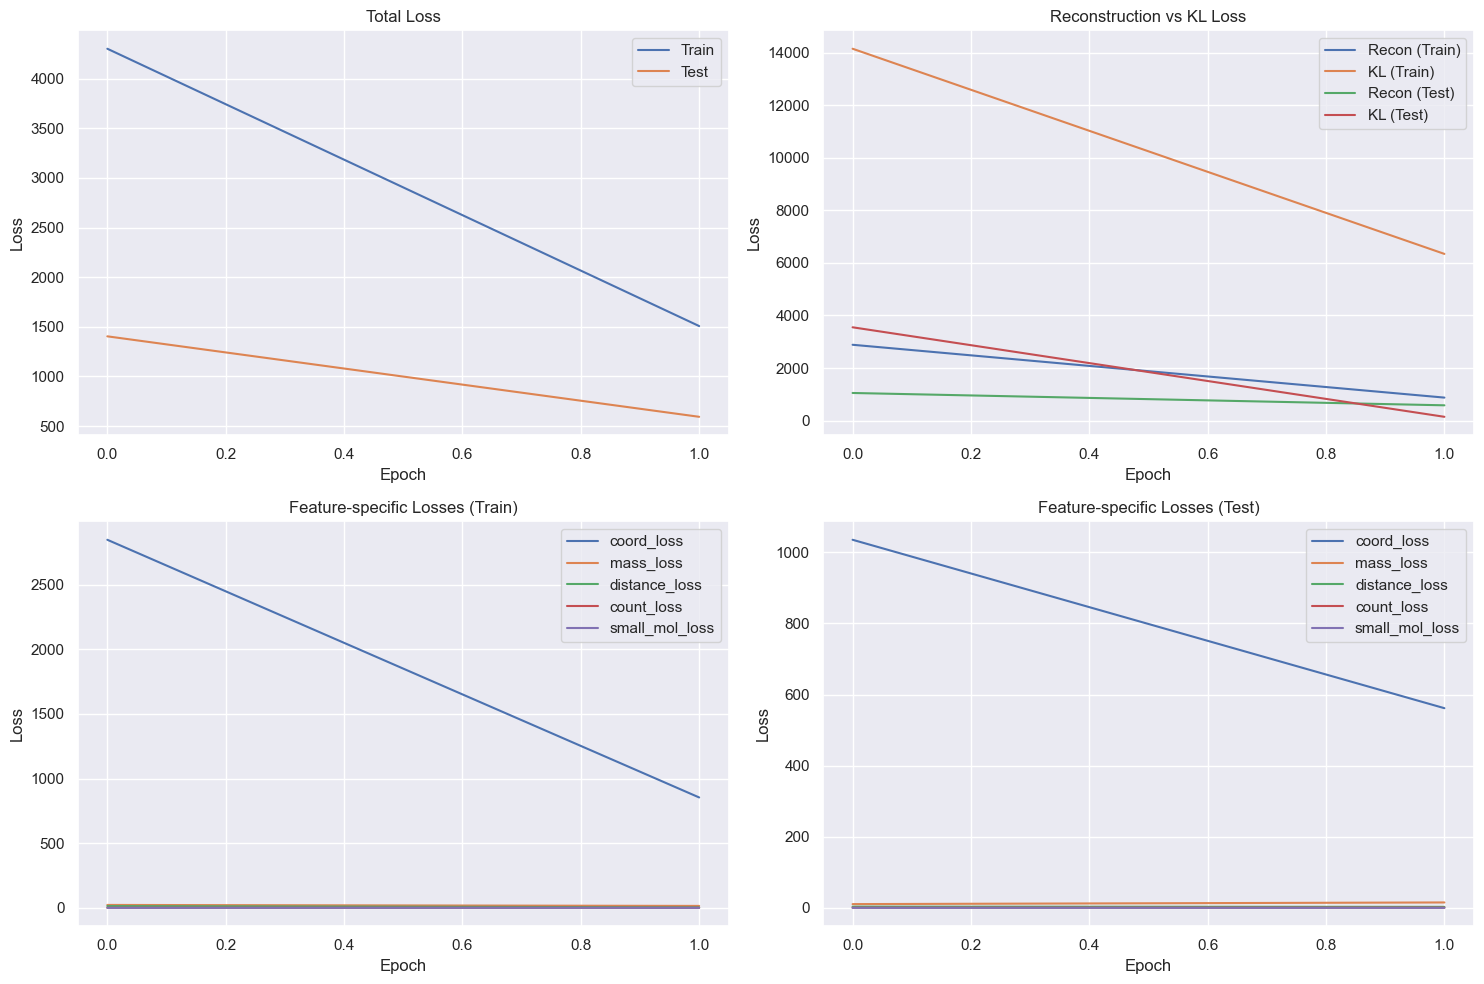

In [70]:
# First, prepare your data with specific batch size
train_loader, test_loader, in_channels = prepare_graphs_for_vae(
    graphs,
    batch_size=2,  # Specify your batch size here
    train_ratio=0.8,
    shuffle=True
)

# Initialize your model
model = ProteinGraphVAE(
    in_channels=in_channels,
    hidden_channels=64,
    latent_channels=32
)

# Train with specific number of epochs
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=2,  # Specify number of epochs here
    beta=0.1  # Optional: control KL divergence weight
)

Using device: cpu
Dataset prepared:
Number of training graphs: 176
Number of test graphs: 45
Number of features per node: 8
Batch size: 2


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


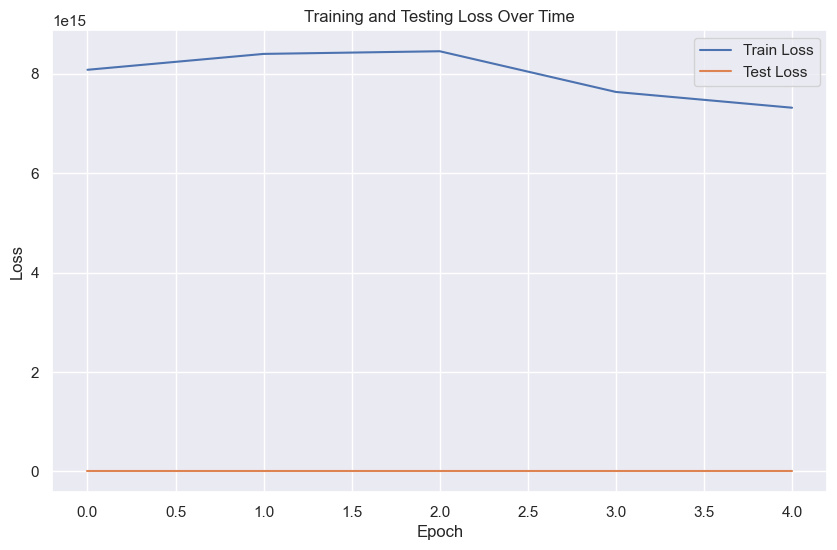

In [81]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_protein_graphs(model, num_samples=1, nodes_per_graph=100, device='cuda', temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_samples, model.fc_mu.out_features, device=device) * temperature

        # Decode the latent vectors
        decoded = model.decode(z, num_samples, nodes_per_graph)

        # Process each generated graph
        for i in range(num_samples):
            # Extract features for this graph
            features = decoded[i]  # Should be [nodes, features]

            # Add small random variations to coordinates
            coords = features[:, -3:] + torch.randn_like(features[:, -3:]) * 0.1

            # Ensure other features are reasonable
            mass = torch.abs(features[:, 0]).unsqueeze(1)  # Positive mass
            distances = torch.abs(features[:, 1:3])  # Positive distances
            counts = torch.round(torch.abs(features[:, 3])).unsqueeze(1)  # Integer counts
            small_mols = (features[:, 4] > 0.5).float().unsqueeze(1)  # Binary

            # Combine features
            node_features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)

            # Generate edges
            edge_index = []
            edge_attr = []

            for j in range(len(coords)):
                for k in range(j + 1, len(coords)):
                    dist = torch.norm(coords[j] - coords[k])
                    if dist < 5.0:
                        edge_index.extend([[j, k], [k, j]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=node_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def interpolate_proteins(model, protein1, protein2, num_steps=10, device='cuda'):
    """
    Generate interpolated proteins between two existing proteins
    
    Args:
        model: Trained VAE model
        protein1: First protein graph (PyG Data object)
        protein2: Second protein graph (PyG Data object)
        num_steps: Number of interpolation steps
        device: Device to run interpolation on
    
    Returns:
        list of Interpolated graphs
    """
    model.eval()
    model = model.to(device)

    # Convert proteins to batches
    batch1 = torch.zeros(protein1.x.size(0), dtype=torch.long)
    batch2 = torch.zeros(protein2.x.size(0), dtype=torch.long)

    # Get latent representations
    with torch.no_grad():
        protein1 = protein1.to(device)
        protein2 = protein2.to(device)

        mu1, _ = model.encode(protein1.x, protein1.edge_index, batch1)
        mu2, _ = model.encode(protein2.x, protein2.edge_index, batch2)

        # Interpolate in latent space
        interpolated_graphs = []
        alphas = np.linspace(0, 1, num_steps)

        max_nodes = max(protein1.x.size(0), protein2.x.size(0))

        for alpha in alphas:
            # Interpolate latent vectors
            z = (1 - alpha) * mu1 + alpha * mu2

            # Decode
            decoded = model.decode(z.unsqueeze(0), 1, max_nodes)[0]

            # Process decoded features (similar to generate_protein_graphs)
            mass = decoded[:, model.mass_index].unsqueeze(1)
            distances = decoded[:, model.distance_indices]
            counts = decoded[:, model.count_index].unsqueeze(1)
            small_mols = (decoded[:, model.small_mol_index].unsqueeze(1) > 0.5).float()
            coords = decoded[:, -3:]

            # Round and clamp values
            counts = torch.round(counts)
            mass = torch.clamp(mass, min=0)
            distances = torch.clamp(distances, min=0)
            counts = torch.clamp(counts, min=0)

            # Combine features
            node_features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)

            # Generate edges
            edge_index = []
            edge_attr = []

            for i in range(len(coords)):
                for j in range(i + 1, len(coords)):
                    dist = torch.norm(coords[i] - coords[j])
                    if dist < 5.0:
                        edge_index.extend([[i, j], [j, i]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=node_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            interpolated_graphs.append(graph)

    return interpolated_graphs

def visualize_protein_graph(graph, title="Generated Protein Structure"):
    """Improved visualization of protein graph"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates
    coords = graph.x[:, -3:].cpu().numpy()
    masses = graph.x[:, 0].cpu().numpy()  # Use mass for point size
    small_mols = graph.x[:, 4].cpu().numpy()  # Use for coloring

    # Scale masses for visualization
    sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100

    # Plot nodes with size based on mass and color based on small molecules
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=small_mols, cmap='coolwarm',
                         s=sizes, alpha=0.6)

    # Plot edges
    edges = graph.edge_index.cpu().numpy()
    for i in range(0, edges.shape[1], 2):
        start = coords[edges[0, i]]
        end = coords[edges[1, i]]
        ax.plot([start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]], 'gray', alpha=0.2)

    plt.colorbar(scatter, label='Small Molecules')
    ax.set_title(title)

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    plt.show()


# Example usage:
def generate_and_visualize_proteins(model, device='cuda'):
    """
    Generate and visualize some example proteins
    """
    # Generate new proteins
    print("Generating new proteins...")
    generated = generate_protein_graphs(model, num_samples=3, nodes_per_graph=100, device=device)

    # Visualize each generated protein
    for i, graph in enumerate(generated):
        visualize_protein_graph(graph, f"Generated Protein {i+1}")

    return generated

def interpolate_and_visualize(model, protein1, protein2, device='cuda'):
    """
    Interpolate between two proteins and visualize the results
    """
    print("Generating interpolated proteins...")
    interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)

    # Visualize interpolation
    for i, graph in enumerate(interpolated):
        visualize_protein_graph(graph, f"Interpolation Step {i+1}")

    return interpolated

def print_graph_info(graph, title="Graph Info", num_samples=5):
    print(f"\n{title}")
    print(f"Node features shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")

    # Print feature statistics
    print("\nFeature statistics:")
    print(f"Mass range: {graph.x[:, 0].min().item():.2f} to {graph.x[:, 0].max().item():.2f}")
    print(f"Avg Neighbor Dist range: {graph.x[:, 1].min().item():.2f} to {graph.x[:, 1].max().item():.2f}")
    print(f"Max Neighbor Dist range: {graph.x[:, 2].min().item():.2f} to {graph.x[:, 2].max().item():.2f}")
    print(f"Neighbor Count range: {graph.x[:, 3].min().item():.2f} to {graph.x[:, 3].max().item():.2f}")
    print(f"Small Molecules ratio: {graph.x[:, 4].mean().item():.2f}")

    print("\nSample nodes:")
    for i in range(min(num_samples, len(graph.x))):
        features = graph.x[i]
        print(f"\nNode {i}:")
        print(f"  Mass: {features[0].item():.2f}")
        print(f"  Avg/Max Neighbor Dist: {features[1].item():.2f}/{features[2].item():.2f}")
        print(f"  Neighbor Count: {features[3].item():.0f}")
        print(f"  Small Molecules: {features[4].item():.0f}")
        print(f"  Coordinates: ({features[5].item():.2f}, {features[6].item():.2f}, {features[7].item():.2f})")


Graph Info
Node features shape: torch.Size([100, 8])
Edge index shape: torch.Size([2, 9900])

Feature statistics:
Mass range: 0.63 to 0.63
Avg Neighbor Dist range: 0.15 to 0.15
Max Neighbor Dist range: 0.09 to 0.09
Neighbor Count range: 0.00 to 0.00
Small Molecules ratio: 1.00

Sample nodes:

Node 0:
  Mass: 0.63
  Avg/Max Neighbor Dist: 0.15/0.09
  Neighbor Count: 0
  Small Molecules: 1
  Coordinates: (0.37, 0.35, 0.59)

Node 1:
  Mass: 0.63
  Avg/Max Neighbor Dist: 0.15/0.09
  Neighbor Count: 0
  Small Molecules: 1
  Coordinates: (0.55, 0.21, 0.60)

Node 2:
  Mass: 0.63
  Avg/Max Neighbor Dist: 0.15/0.09
  Neighbor Count: 0
  Small Molecules: 1
  Coordinates: (0.62, 0.25, 0.42)

Node 3:
  Mass: 0.63
  Avg/Max Neighbor Dist: 0.15/0.09
  Neighbor Count: 0
  Small Molecules: 1
  Coordinates: (0.62, 0.22, 0.60)

Node 4:
  Mass: 0.63
  Avg/Max Neighbor Dist: 0.15/0.09
  Neighbor Count: 0
  Small Molecules: 1
  Coordinates: (0.62, 0.34, 0.61)


/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_6918/3600476877.py:166: RuntimeWarning: invalid value encountered in divide
  sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100


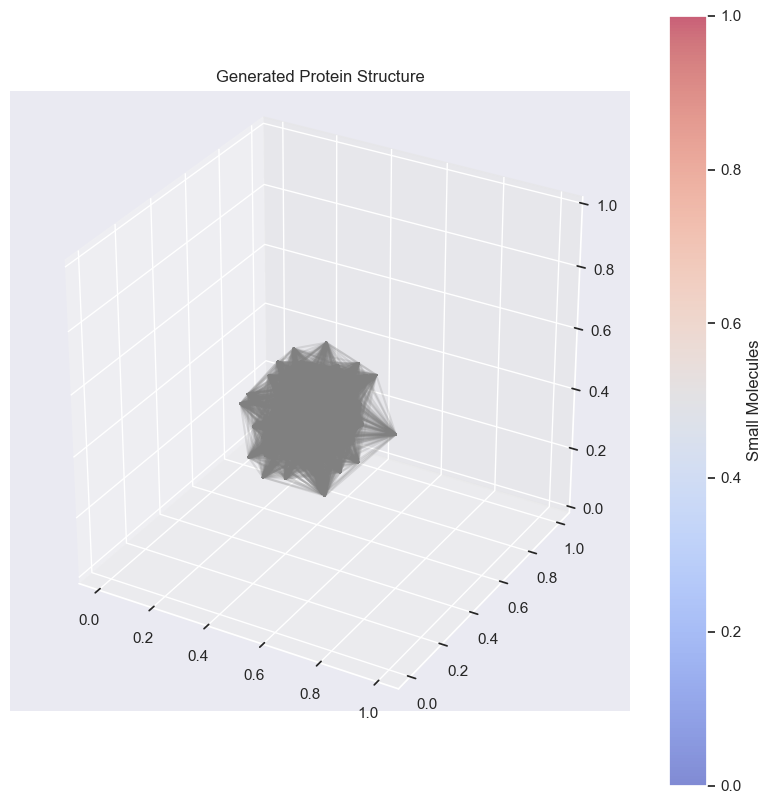

In [83]:
generated = generate_protein_graphs(model, num_samples=10, nodes_per_graph=100, device=device)
print_graph_info(generated[0])
visualize_protein_graph(generated[0])